# Brain Activity and Functional Connectivity during Working Memory Task

A project undertaken by Ahmad Samara, Romeo Penheiro, and Saksham Pruthi during the Neuromatch Academy 2021 as part of the group brave-neurons and pod partial-cows.

We wholeheartedly acknowledge Dr. Jonathan Wirsirch (Project Mentor), Nicholas Blauch (Project TA), and Ishani Ganguly (Pod TA) for their valuable guidance and mentorship. We also acknowledge all the efforts, opportunities, and support provided by the entire Neuromatch Academy team.

We used the HCP 2020 dataset notebook made available by Neuromatch Academy and modified that to build our project.

# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
# Necessary for visualization
!pip install nilearn --quiet
from nilearn import plotting, datasets, image

     |████████████████████████████████| 4.9 MB 34.8 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Figure Helper Functions

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0], # Changed from name=regions[0].tolist()
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [ ]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## HRF and GLM

In [ ]:
def get_HRF(duration,TR,peak):
  """
  Really dumb Haemodynamic response function (not physiologically plausible)
  It simply goes up and down linearly from 0 to peak and back down

  Args:
    duration (float) : in seconds
    TR (float)       : in seconds 
    peak (float)     : in seconds

  Returns:
    1D array
  """
  n = int(np.ceil(duration/TR))
  x = np.linspace(0,duration,n)
  h = np.zeros(n)
  h[x<peak]  = x[x<peak]/peak
  h[x>=peak] = (x[x>=peak]-duration)/(peak-duration)
  h = h/np.sum(h)
  return h


def glm(Y,X,C=None,mask=None):
  """
  Run a general linear model

  Args:
    Y (2d array) : time-by-space data matrix
    X (2d array) : time-by-regressors design matrix
    C (2d array) : contrasts-by-regressor contrrast matrix [default=Identity]
    mask (1d array) : spatial mask wherre GLM is run

  Returns:    
    contrast maps
    t-stats
  """
  if C is None:
    C = np.identity(X.shape[1])
  if mask is None:
    mask = np.ones(Y.shape[1]).astype(int)

  # initialise matrices
  beta    = np.zeros((X.shape[1],Y.shape[1]))
  cope    = np.zeros((C.shape[0],Y.shape[1]))
  varbeta = np.zeros_like(beta)
  tstat   = np.zeros((C.shape[0], Y.shape[1]))

  # solve glm
  beta[:,mask>0] = np.linalg.pinv(X)@Y[:,mask>0]
  # apply contrasts
  cope[:,mask>0] = np.dot(C,beta[:,mask>0])

  # calculate uncertainty (varcope)
  r    = Y - X@beta
  dof  = X.shape[0] - np.linalg.matrix_rank(X)
  sig2 = np.sum(r**2,axis=0)/dof
#   varcope = np.outer(C@np.linalg.inv(X.T@X)@C.T,sig2)
  varcope = np.outer(np.diag(C@np.linalg.inv(X.T@X)@C.T),sig2)
  # calculate t-stats
  tstat[:,mask] = cope[:,mask] / np.sqrt(varcope[:,mask])

  return cope, tstat

# Working Memory Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for the WM task:

```
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
```

## Load timeseries data

Load timeseries data for any one subject for rest/task conditions

In [ ]:
timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


In [ ]:
timeseries = load_timeseries(subject=284, name="WM_RL", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 405)


Load timeseries data for all subjects for rest/task conditions concatenated/not concatenated across runs

In [ ]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "WM", concat=False))

In [ ]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

In [ ]:
timeseries_task_fc = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "WM")
  timeseries_task_fc.append(ts_concat)

In [ ]:
print(len(timeseries_task_fc))

339


## Contrast analysis

In [ ]:
help(load_evs)

In [ ]:
help(selective_average)

Contrast Analysis across 2 back and 0 back conditions averaged across all subjects

In [ ]:
task = "WM"
conditions = ['2bk_body', '0bk_body', '2bk_faces', '0bk_faces', '2bk_tools', '0bk_tools']  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1] + avgs[2] - avgs[3] + avgs[4] - avgs[5])

group_contrast = np.mean(contrast, axis=0)
group_contrast.shape

(360,)

Plot group-averaged contrast value (2 back v/s 0 back across regions:

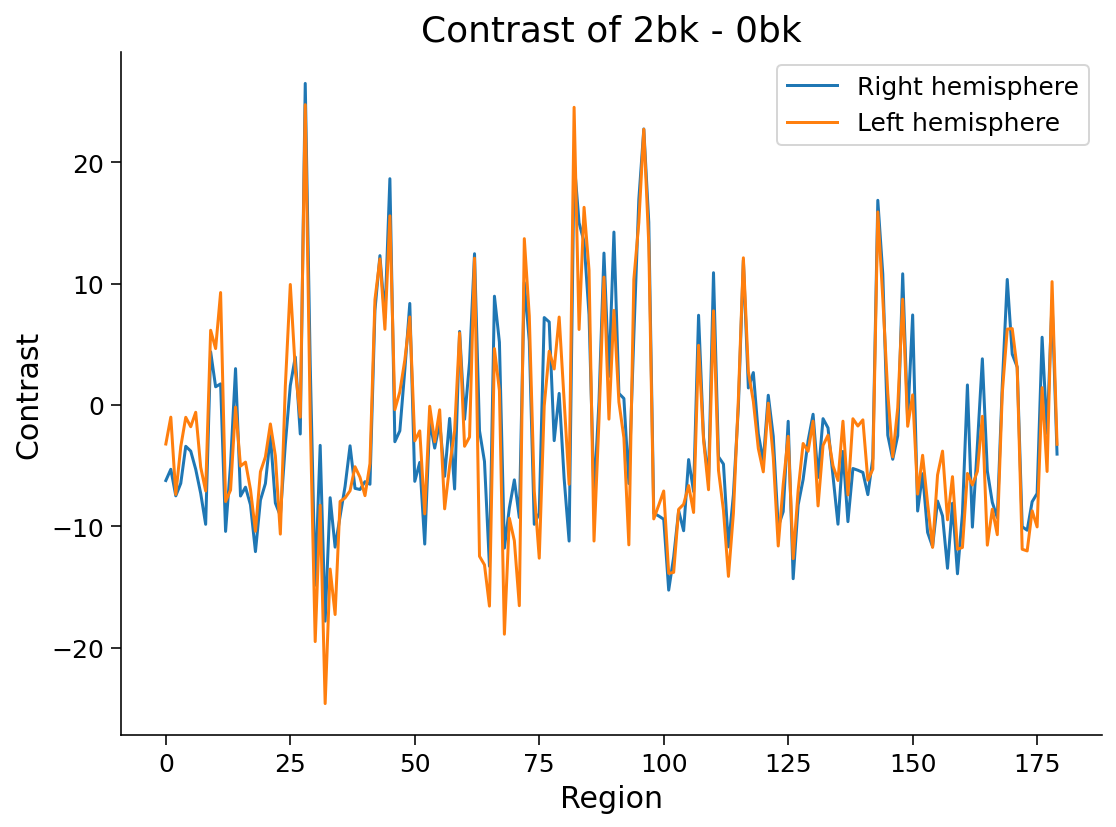

In [ ]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of 2bk - 0bk")
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

Plot the regional values on the surface of one hemisphere:

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=15)

## Characterize values across regions or networks

Plot contrast values (amplitude difference) sorted across regions and separated across brain hemispheres

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


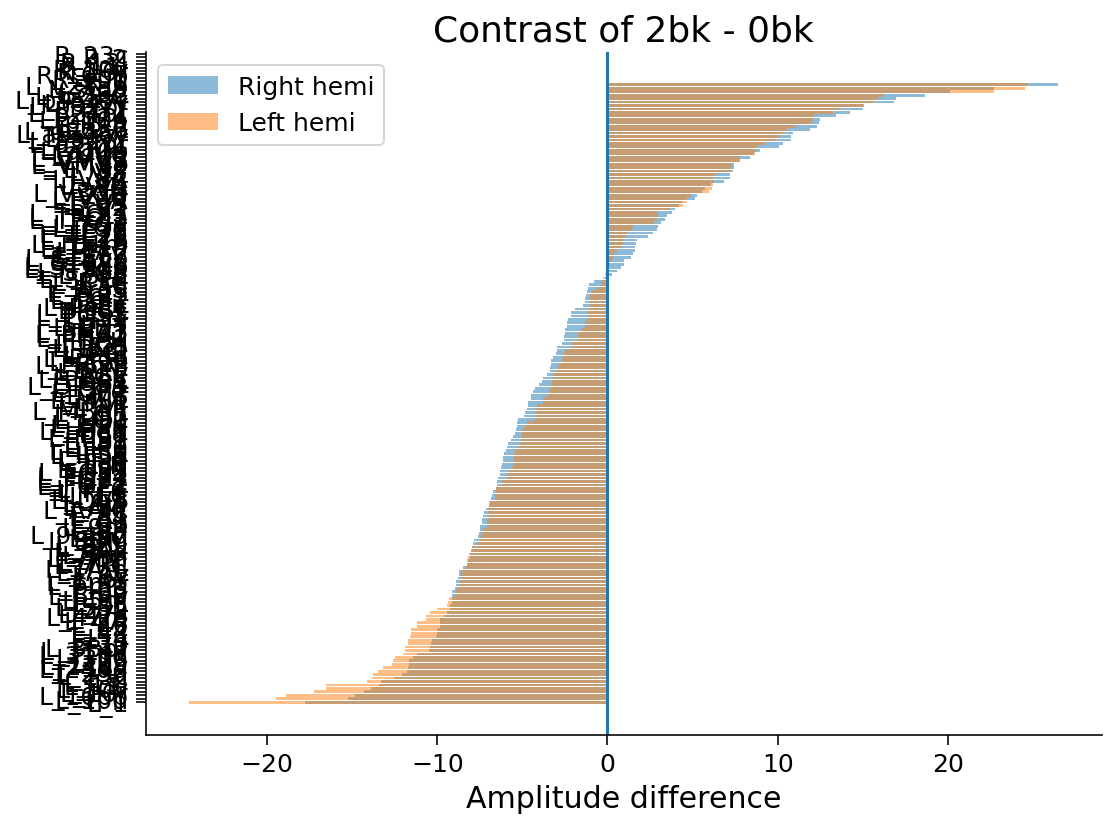

In [ ]:
# Get unique areas[or regions] labels
area_names = np.unique(region_info["name"])

hemi_networks = np.split(region_info["name"], 2)
hemi_contrasts = np.split(group_contrast, 2)
# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for area in area_names:
    network_vals.append(hemi_contrast[hemi_network == area].mean())
    #print(area)
  plt.barh(area_names, np.sort(network_vals), alpha=.5, label=f"{hemi} hemi")
#print(len(network_vals))
plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of 2bk - 0bk")
plt.legend()
plt.show()

Plot contrast values (amplitude difference) across defined networks (average parcel values belonging to each network) and separated across brain hemispheres

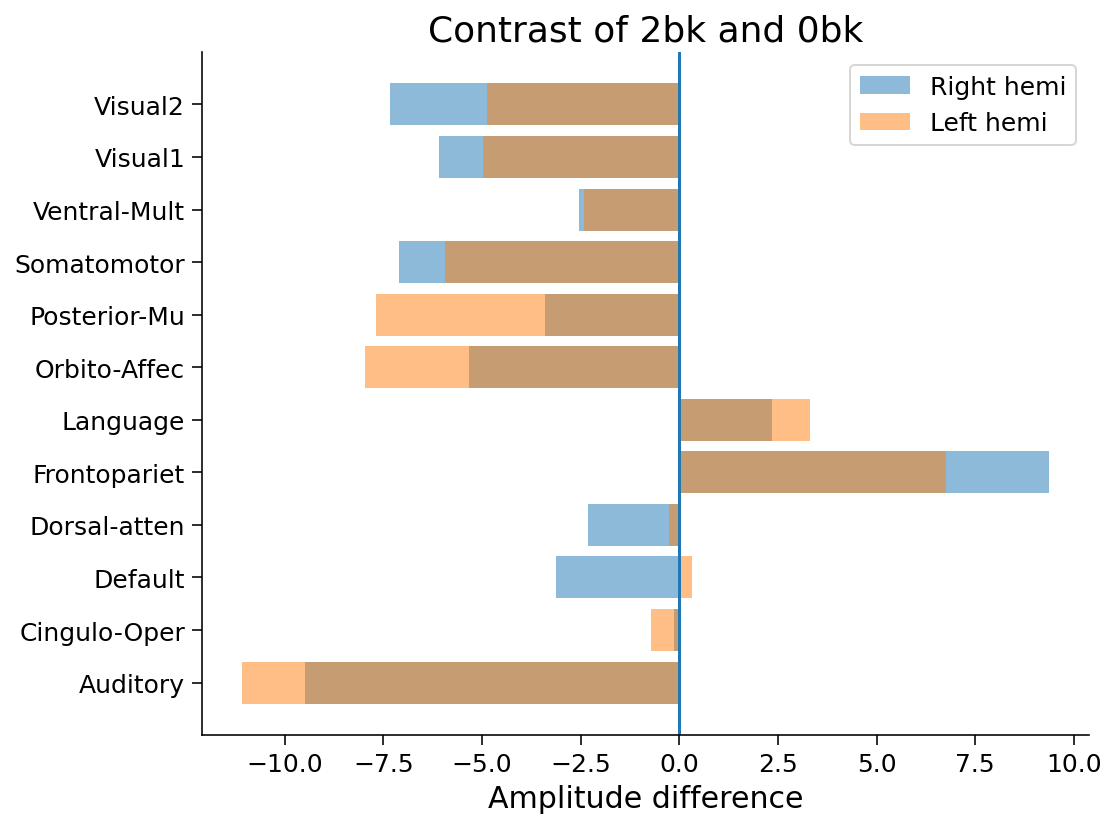

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals_nw = []
  for network in network_names:
    network_vals_nw.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals_nw, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of 2bk and 0bk")
plt.legend()
plt.show()

# Generalised Linear Model

Perform a GLM based analysis to regress working memory stimulus (2bk v/s 0bk) against fMRI time series convolved with HRF and use beta-values and uncertainity in beta-values to determine regions which respond to Working Memory task.


## GLM for a single subject for one run

In [ ]:
data = load_timeseries(subject=subjects[1], name='WM', runs=1, remove_mean=True)

data.shape
#print(data[0, :])

(360, 405)

Load EV (explanatory variable) data for one task condition for one subject and identify timepoints using onset and duration values

In [ ]:
evs_2bk_body = load_evs(subject=subjects[1], name='WM', condition='2bk_body')
data_required_for_hrf_2bk_body = condition_frames(evs_2bk_body, skip=0)

evs_0bk_body = load_evs(subject=subjects[1], name='WM', condition='0bk_body')
data_required_for_hrf_0bk_body = condition_frames(evs_0bk_body, skip=0)

evs_2bk_faces = load_evs(subject=subjects[1], name='WM', condition='2bk_faces')
data_required_for_hrf_2bk_faces = condition_frames(evs_2bk_faces, skip=0)

evs_0bk_faces = load_evs(subject=subjects[1], name='WM', condition='0bk_faces')
data_required_for_hrf_0bk_faces = condition_frames(evs_0bk_faces, skip=0)

evs_2bk_tools = load_evs(subject=subjects[1], name='WM', condition='2bk_tools')
data_required_for_hrf_2bk_tools = condition_frames(evs_2bk_tools, skip=0)

evs_0bk_tools = load_evs(subject=subjects[1], name='WM', condition='0bk_tools')
data_required_for_hrf_0bk_tools = condition_frames(evs_0bk_tools, skip=0)

#evs_2bk_places = load_evs(subject=subjects[1], name='WM', condition='2bk_places')
#data_required_for_hrf_2bk_places = condition_frames(evs_2bk_places, skip=0)

#evs_0bk_places = load_evs(subject=subjects[1], name='WM', condition='0bk_places')
#data_required_for_hrf_0bk_places = condition_frames(evs_0bk_places, skip=0)

Concatenate the timepoints so obtained for every condition to define a continuous timeseries

In [ ]:
cond1_timecourse = np.zeros(data.shape[1])
cond1_timepoints = np.concatenate(data_required_for_hrf_2bk_body)
cond1_timecourse[cond1_timepoints] = 1

cond2_timecourse = np.zeros(data.shape[1])
cond2_timepoints = np.concatenate(data_required_for_hrf_0bk_body)
cond2_timecourse[cond2_timepoints] = 1

cond3_timecourse = np.zeros(data.shape[1])
cond3_timepoints = np.concatenate(data_required_for_hrf_2bk_faces)
cond3_timecourse[cond3_timepoints] = 1

cond4_timecourse = np.zeros(data.shape[1])
cond4_timepoints = np.concatenate(data_required_for_hrf_0bk_faces)
cond4_timecourse[cond4_timepoints] = 1

cond5_timecourse = np.zeros(data.shape[1])
cond5_timepoints = np.concatenate(data_required_for_hrf_2bk_tools)
cond5_timecourse[cond5_timepoints] = 1

cond6_timecourse = np.zeros(data.shape[1])
cond6_timepoints = np.concatenate(data_required_for_hrf_0bk_tools)
cond6_timecourse[cond6_timepoints] = 1

#cond9_timecourse = np.zeros(data.shape[1])
#cond9_timepoints = np.concatenate(data_required_for_hrf_2bk_places)
#cond9_timecourse[cond1_timepoints] = 1

#cond10_timecourse = np.zeros(data.shape[1])
#cond10_timepoints = np.concatenate(data_required_for_hrf_0bk_places)
#cond10_timecourse[cond2_timepoints] = 1

In [ ]:
cond1_timecourse.shape

# Run the really dumb hemodynamic response function

HRF = get_HRF(duration=10, TR=0.72, peak=6)

The hemodynamic response function accounts for the delay in reaching the peak by the BOLD signal which is measured by the fMRI. The HRF function used is not what is physiologically observed, but it simply accounts for the delay in peak.

Convolve the timeseries data for each condition with HRF to obtain better and more-accounted for results.

In [ ]:
pred_ts1 = np.convolve(cond1_timecourse, HRF, 'full')[:data.shape[1]]
pred_ts2 = np.convolve(cond2_timecourse, HRF, 'full')[:data.shape[1]]
pred_ts3 = np.convolve(cond3_timecourse, HRF, 'full')[:data.shape[1]]
pred_ts4 = np.convolve(cond4_timecourse, HRF, 'full')[:data.shape[1]]
pred_ts5 = np.convolve(cond5_timecourse, HRF, 'full')[:data.shape[1]]
pred_ts6 = np.convolve(cond6_timecourse, HRF, 'full')[:data.shape[1]]
#pred_ts9 = np.convolve(cond9_timecourse, HRF, 'full')[:data.shape[1]]
#pred_ts10 = np.convolve(cond10_timecourse, HRF, 'full')[:data.shape[1]]

In [ ]:
pred_ts1.shape

(405,)

Plot the convolved timeseries

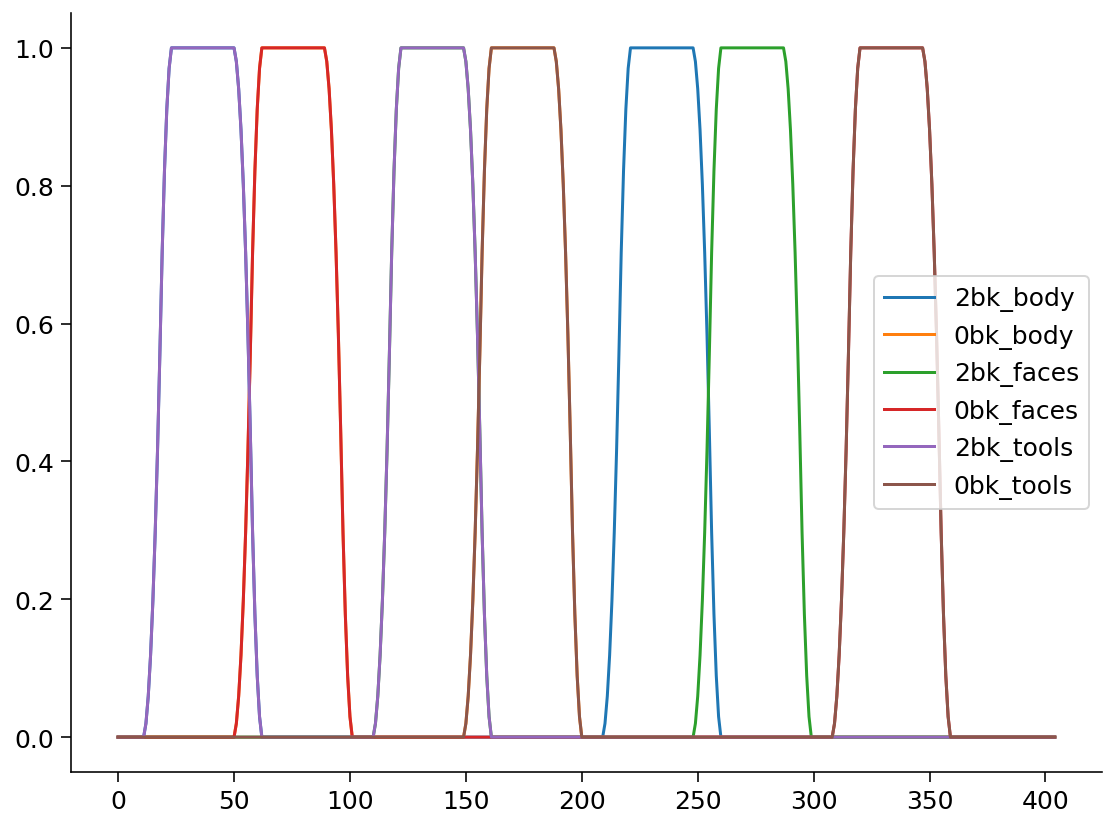

In [ ]:
#plt.plot(cond1_timecourse, label="2bk_body")
plt.plot(pred_ts1, label="2bk_body")
#plt.plot(cond2_timecourse, label="0bk_body")
plt.plot(pred_ts2, label="0bk_body")
#plt.plot(cond3_timecourse, label="2bk_faces")
plt.plot(pred_ts3, label="2bk_faces")
#plt.plot(cond4_timecourse, label="0bk_faces")
plt.plot(pred_ts4, label="0bk_faces")
#plt.plot(cond5_timecourse, label="2bk_tools")
plt.plot(pred_ts5, label="2bk_tools")
#plt.plot(cond6_timecourse, label="0bk_tools")
plt.plot(pred_ts6, label="0bk_tools")
#plt.plot(cond7_timecourse, label="2bk_nir")
#plt.plot(pred_ts7)
#plt.plot(cond8_timecourse, label="0bk_nir")
#plt.plot(pred_ts8)
#plt.plot(cond9_timecourse, label="2bk_placed")
#plt.plot(pred_ts9)
#plt.plot(cond10_timecourse, label="0bk_placed")
#plt.plot(pred_ts10)
plt.legend()

Build the design matrix

(405, 7)


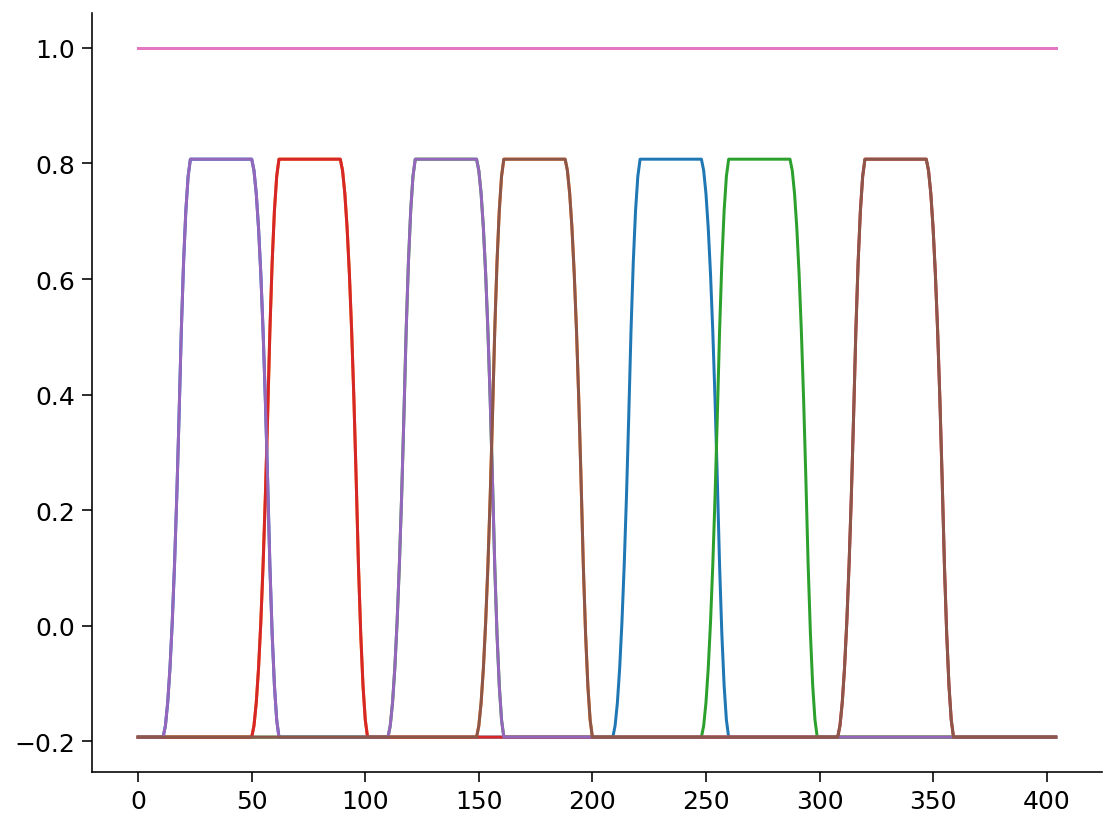

In [ ]:
# Design Matrix

pred_ts1_design = pred_ts1 - np.mean(pred_ts1)
pred_ts2_design = pred_ts2 - np.mean(pred_ts2)
pred_ts3_design = pred_ts3 - np.mean(pred_ts3)
pred_ts4_design = pred_ts4 - np.mean(pred_ts4)
pred_ts5_design = pred_ts5 - np.mean(pred_ts5)
pred_ts6_design = pred_ts6 - np.mean(pred_ts6)

design_matrix_test = np.asarray([pred_ts1_design, pred_ts2_design, pred_ts3_design, pred_ts4_design, pred_ts5_design, pred_ts6_design, np.ones_like(pred_ts1_design)]).T
print(design_matrix_test.shape)

plt.plot(design_matrix_test)

Construct the contrast matrix as per the analysis to be performed (Default: Identity Matrix)

In [ ]:
matrix_c_test = np.array([1, -1, 1, -1, 1, -1, 0, 
                          -1, 1, -1, 1, -1, 1, 0, 
                          1, -1, 1, -1, 1, -1, 0, 
                          -1, 1, -1, 1, -1, 1, 0, 
                          1, -1, 1, -1, 1, -1, 0, 
                          -1, 1, -1, 1, -1, 1, 0, 
                          0, 0, 0, 0, 0, 0, 0])
matrix_c_test = matrix_c_test.reshape((7,7))
print(matrix_c_test)

[[ 1 -1  1 -1  1 -1  0]
 [-1  1 -1  1 -1  1  0]
 [ 1 -1  1 -1  1 -1  0]
 [-1  1 -1  1 -1  1  0]
 [ 1 -1  1 -1  1 -1  0]
 [-1  1 -1  1 -1  1  0]
 [ 0  0  0  0  0  0  0]]


In [ ]:
matrix_c = np.array([1, -1, 1, -1, 1, -1, 0, 
                     0, 0, 0, 0, 0, 0, 0, 
                     0, 0, 0, 0, 0, 0, 0, 
                     0, 0, 0, 0, 0, 0, 0, 
                     0, 0, 0, 0, 0, 0, 0, 
                     0, 0, 0, 0, 0, 0, 0, 
                     0, 0, 0, 0, 0, 0, 0])
matrix_c = matrix_c.reshape((7,7))
print(matrix_c)

[[ 1 -1  1 -1  1 -1  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


Implement the GLM

In [ ]:
# Implementing the GLM

Y = data.T
print(Y.shape)
#print(Y.shape)
#print(design_matrix_test.shape[1])
beta,t = glm(Y=Y,X=design_matrix_test, C=matrix_c_test)

#print(Y.shape)
print(t.shape)
print(beta.shape)

(405, 360)
(7, 360)
(7, 360)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


[0. 0. 0. 0. 0. 0. 0.]
[ 64.62325787  -5.6587418   13.71050788  40.45274317  62.85507324
  88.67321511  90.09832534 -40.19651361 -24.24080805  42.42368466]


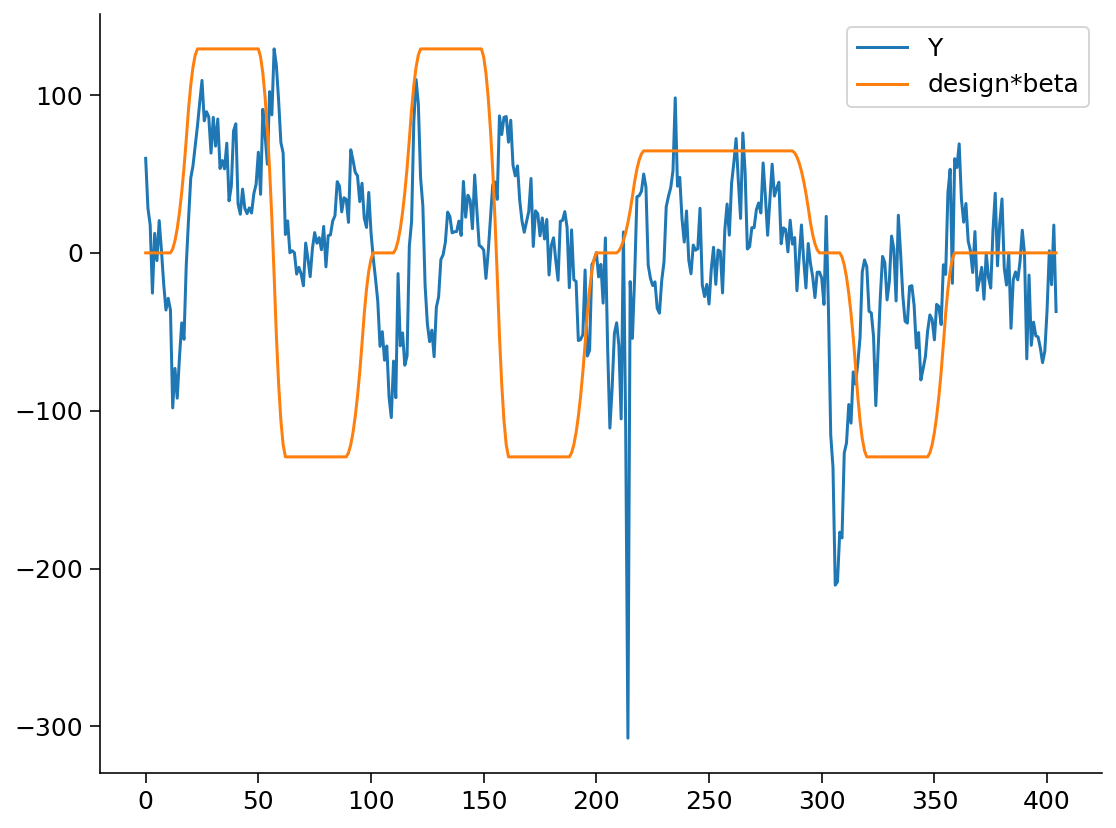

In [ ]:
idx = np.argmax(t[0,:])
print(t[:, idx])
print(beta[0,0:10])
#plt.plot(t[1,:])
plt.plot(Y[:,idx], label = 'Y')
plt.plot(design_matrix_test@beta[:,idx], label = 'design*beta')
plt.legend()

Testing for significance

In [ ]:
t_value, p_value = scipy.stats.ttest_1samp(beta, popmean=(360,), axis=0)
print(p_value[0:10])

[6.12994447e-06 2.96669233e-12 5.98548627e-10 3.85131268e-07
 5.20980671e-06 3.84695779e-05 4.21537425e-05 3.70856102e-07
 1.81574578e-08 5.10920271e-07]


In [ ]:
print(beta.shape)
print(t[:, 1])

(7, 360)
[-0.66125118  0.66125118 -0.66125118  0.66125118 -0.66125118  0.66125118
         nan]


## GLM for all subjects for both runs

Extrapolate the GLM above for analysis of data from all subjects and obtain average beta values

(18 subjects were not used in this analysis as the design matrix obtained was a singular matrix)



In [ ]:
beta_all = []
t_all = []
i=0

# Trying a GLM for all subjects

for subject in subjects:
  
  #print(i)
  i+=1
  if subject==12 or subject==39 or subject==67 or subject==70 or subject==77 or subject==108 or subject==121 or subject==133:
    continue
  elif subject==148 or subject==156 or subject==159 or subject==180 or subject==221 or subject==222 or subject==236:
    continue
  elif subject==286 or subject==297 or subject==319:
    continue
  else:
    p = 0
  
  # Load timeseries for one subject
  data = load_timeseries(subject=subject, name='WM', runs=1, remove_mean=True)
  

  # Load EVS for one subject for all conditions (we can )
  evs_2bk_body = load_evs(subject=subject, name='WM', condition='2bk_body')
  data_required_for_hrf_2bk_body = condition_frames(evs_2bk_body, skip=0)

  evs_0bk_body = load_evs(subject=subject, name='WM', condition='0bk_body')
  data_required_for_hrf_0bk_body = condition_frames(evs_0bk_body, skip=0)

  evs_2bk_faces = load_evs(subject=subject, name='WM', condition='2bk_faces')
  data_required_for_hrf_2bk_faces = condition_frames(evs_2bk_faces, skip=0)

  evs_0bk_faces = load_evs(subject=subject, name='WM', condition='0bk_faces')
  data_required_for_hrf_0bk_faces = condition_frames(evs_0bk_faces, skip=0)

  evs_2bk_tools = load_evs(subject=subject, name='WM', condition='2bk_tools')
  data_required_for_hrf_2bk_tools = condition_frames(evs_2bk_tools, skip=0)

  evs_0bk_tools = load_evs(subject=subject, name='WM', condition='0bk_tools')
  data_required_for_hrf_0bk_tools = condition_frames(evs_0bk_tools, skip=0)
  

  # Tmecourses for all conditions for one subject

  cond1_timecourse = np.zeros(data.shape[1])
  cond1_timepoints = np.concatenate(data_required_for_hrf_2bk_body)
  cond1_timecourse[cond1_timepoints] = 1

  cond2_timecourse = np.zeros(data.shape[1])
  cond2_timepoints = np.concatenate(data_required_for_hrf_0bk_body)
  cond2_timecourse[cond2_timepoints] = 1

  cond3_timecourse = np.zeros(data.shape[1])
  cond3_timepoints = np.concatenate(data_required_for_hrf_2bk_faces)
  cond3_timecourse[cond3_timepoints] = 1

  cond4_timecourse = np.zeros(data.shape[1])
  cond4_timepoints = np.concatenate(data_required_for_hrf_0bk_faces)
  cond4_timecourse[cond4_timepoints] = 1

  cond5_timecourse = np.zeros(data.shape[1])
  cond5_timepoints = np.concatenate(data_required_for_hrf_2bk_tools)
  cond5_timecourse[cond5_timepoints] = 1

  cond6_timecourse = np.zeros(data.shape[1])
  cond6_timepoints = np.concatenate(data_required_for_hrf_0bk_tools)
  cond6_timecourse[cond6_timepoints] = 1

  
  # Convolve timecourses with HRF (Really dumb HRF)

  pred_ts1 = np.convolve(cond1_timecourse, HRF, 'full')[:data.shape[1]]
  pred_ts2 = np.convolve(cond2_timecourse, HRF, 'full')[:data.shape[1]]
  pred_ts3 = np.convolve(cond3_timecourse, HRF, 'full')[:data.shape[1]]
  pred_ts4 = np.convolve(cond4_timecourse, HRF, 'full')[:data.shape[1]]
  pred_ts5 = np.convolve(cond5_timecourse, HRF, 'full')[:data.shape[1]]
  pred_ts6 = np.convolve(cond6_timecourse, HRF, 'full')[:data.shape[1]]


  # Building the design matrix

  pred_ts1_design = pred_ts1 - np.mean(pred_ts1)
  pred_ts2_design = pred_ts2 - np.mean(pred_ts2)
  pred_ts3_design = pred_ts3 - np.mean(pred_ts3)
  pred_ts4_design = pred_ts4 - np.mean(pred_ts4)
  pred_ts5_design = pred_ts5 - np.mean(pred_ts5)
  pred_ts6_design = pred_ts6 - np.mean(pred_ts6)

  design_matrix_test = np.asarray([pred_ts1_design, pred_ts2_design, pred_ts3_design, pred_ts4_design, pred_ts5_design, pred_ts6_design, np.ones_like(pred_ts1_design)]).T
  
  # Run the GLM
  
  Y = data.T
  beta,t = glm(Y=Y,X=design_matrix_test, C=matrix_c)

  # Append the beta and t values so obtained

  beta_all.append(beta)
  t_all.append(t)

  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in sqrt


Average beta values across subjects

In [ ]:
beta_sum = np.zeros([7,360])

for sub in range(0,320):
  beta_sum = beta_sum + beta_all[sub]

In [ ]:
beta_avg = beta_sum / 321 * 7
#print(beta_sum)
print(beta_avg)

[[ 254.46380714  -74.87556302  -94.74401683 ... -129.53544855
   333.36513654 -105.91529697]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]


Run a statistical t-test to verify regions with the highest activity in a 2 back v/s 0 back analysis with Bonferroni correction applied to p-value

In [ ]:
t_value, p_value = scipy.stats.ttest_1samp(beta_avg, popmean=(360,), axis=0)
p_value_print = p_value.reshape([360, 1])
print(np.log10(p_value*360))

[ -1.39492288  -4.85873375  -4.26860442  -2.35068933  -1.69958384
  -0.47219215   0.05406471  -3.67418613  -3.14597283  -1.62256645
  -0.94863986  -4.30119373  -4.34194044  -7.26354789  -3.66337161
 -11.50053664  -2.11464925  -2.46559108  -2.44210076  -3.06447385
  -3.22630137  -1.23438672  -3.51660293  -4.45607835 -10.253437
  -7.27863978  -3.19422557 -15.39313757   0.86173772  -5.44781941
  -3.00792271  -3.31488289  -1.01217341  -3.0182931   -1.63021276
  -3.81787176  -3.2189742   -3.7709638   -4.7954949   -2.79353962
  -2.15491101  -2.87780332  -1.60651643  -1.35904353  -3.54859303
   0.22571991  -4.64734527  -2.62415919  -3.53692149  -0.42316759
  -4.01888919  -3.83798412  -2.6114992   -4.92820246  -3.78616001
  -5.55860281  -2.48353202  -4.22502036  -2.84612536  -3.24391118
  -1.85356617  -1.61564346   0.55116295  -1.92299603  -1.12308752
  -2.69037548  -1.5093937   -3.70110944  -2.25497384  -3.13973456
  -3.52737536  -2.99026125  -0.37889519  -1.19738629  -2.18465067
  -2.6831017

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
#print(wm_behavior[:5])
print(wm_behavior.dtype.names)
wm_behavior_fc = wm_behavior.reshape([598, 9])
print(wm_behavior_fc[0])

('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')
(0, 0, '2BK_PLACE', 1., 1., 1., 1016., 1016., 1097.)


In [ ]:
#print(wm_behavior["Subject"][17])
print(wm_behavior_fc[597])
print(wm_behavior_fc[597][8][6])

[(338, 0, '2BK_TOOL', 1.   , 1.        , 1. , 1063. , 1124. ,  827.5)
 (338, 1, '0BK_BODY', 0.7  , 0.875     , 0. , 1118. , 1118. ,    nan)
 (338, 1, '0BK_FACE', 0.8  , 0.875     , 0.5,  835. , 1027. ,  561. )
 (338, 1, '0BK_PLACE', 1.   , 1.        , 1. ,  671. ,  716.5,  641.5)
 (338, 1, '0BK_TOOL', 1.   , 1.        , 1. ,  612.5,  643.5,  564.5)
 (338, 1, '2BK_BODY', 0.875, 0.83333333, 1. , 1319. , 1319. , 1434. )
 (338, 1, '2BK_FACE', 0.625, 0.66666667, 0.5, 1469. , 1525. ,  679. )
 (338, 1, '2BK_PLACE', 1.   , 1.        , 1. , 1416. , 1416. , 1014.5)
 (338, 1, '2BK_TOOL', 0.875, 0.83333333, 1. , 1275. , 1333. ,  665.5)]
1275.0


In [ ]:
"""
median_rt_avg = []
subject=0
median_rt_sum=0

for idx1 in range(598):
  for idx2 in range(9):
    if (wm_behavior_fc[idx1][idx2][0])==(subjects[subject]):
      median_rt_sum += wm_behavior_fc[idx1][idx2][6]
      num+=1
    else:
      median_rt_avg.append((median_rt_sum/num))
      subject+=1
      idx2-=1
      num=0
      median_rt_sum=0

print(median_rt_avg[:5])

Extract median response time values for all subjects averaged across all 2 back conditions

In [ ]:
median_rt_avg = [1054.438, 865.5625, 940.5625, 798, 864.0625, 996, 1045.75, 778.75, 1052.125, 977.0625, 1040.375, 904.75, 
                 1092.25, 1061.438, 1019.125, 897.3125, 987.0625, 802.9375, 1004.313, 858.6875, 999.5, 904.75, 892.875, 
                 827.9375, 1122.625, 1109.375, 869.375, 1012.188, 1313.563, 1103.375, 988.6875, 806.1875, 1155.375,
                 709.1875, 1103.813, 1150.125, 855.75, 1144.875, 1161.375, 948.3125, 1013.375, 1094.25, 1123.563, 1007.625, 
                 1024.5, 1291.625, 1003.875, 929.875, 983.0625, 1177.563, 1034.813, 1150.375, 1007.813, 876.375, 1207.688,
                 876.8125, 1071.25,1025.188,865.9375,1025,1229.188,1089.563,939.875,782.9375,830.875,892.75,1059.188,1062.25,
                 873.3125,989.5625,803.6875,819.5,1061.188,957.4375,1307.063,978.5,1020.438,1067.5,1125.188,909.3125,
                 1026.375,1081.875,960.625,811.8125,741.5,1178.625,932.1875,1065.188,971.9375,1019.438,1252.75,970.375,
                 873.875,884.25,848.875,1051.125,992.6875,912.25,899.8125,918.625,961.6875,1057.688,686.625,1042.25,776.5,
                 1021.125,1031.25,830.3125,1171.875,953.125,888.25,768.6875,880.125,701.375,951.1875,994.0625,866.8125,
                 945.3125,797,1479.75,942.8125,1027.5,778.1875,772.5625,868.1875,1139.75,887.5625,823.25,1315.625,902,1120.938,
                 971.0625,860.5,942.125,898.3125,793.375,958.0625,1272.813,773.1875,875.4375,827.8125,951.75,979.0625,878.125,
                 923.5625,1065.938,1233.375,1106.563,905.3125,904.625,858.625,812.875,850.1875,965.125,987.4375,625.6875,
                 820.6875,1080.625,1137,918.4375,1150.188,705.25,1166.063,975.0625,930.8125,721.875,880.1875,613.6875,847.25,
                 1133.188,1022.313,824.6875,1076.875,1201,1031.813,953.1875,1012.188,1075.5,1083.375,847,878.1875,
                 1128.375,1358.188,819.375,1102.563,986.5,1366.625,949.125,978.0625,800.375,1268.938,926.3125,1041.75,
                 740.3125,883.9375,801.5625,1138.313,962.9375,606.75,1157.063,1041.563,1021.813,799.3125,855.375,1015.75,
                 774.1875,832.375,890.3125,1015.5,1003,1038.75,1238.688,995.875,1019.563,813.0625,1045.313,951.3125,1133.125,
                 1070.438,774.6875,1106.688,1054.938,1012.75,921,889.875,946.75,1210.625,903.0625,1026.375,907.1875,
                 1385.313,1175.313,974.75,1158,1300.875,860.75,889.9375,819.9375,638,1088.188,1180.5,1083.625,890.4375,
                 1283.688,988.75,841.75,897.0625,1008.875,1036,1118.625,911.25,1173.688,1211.125,888.9375,915.4375,845.625,960.875,
                 922.75,981.5,984.0625,713.25,1016.688,809.8125,1195.313,965.375,1107.063,1279.25,719.5625,824.75,
                 1131,989.3125,1253.5,901.75,904.375,925.0625,949.8125,1207.313,632.9375,970.25,968.625,961.125,
                 774.6875,963.75,1142.188,946.625,811.3125,566.3125,971.4375,716.9375,864.375,1219.375,771.5,921.8125,
                 821.875,900.3125,1082.313,1160.563,1227.375,738.375,1149.125,849.875,811.3125,975.4375,1011.438,1052.063,
                 759.8125,824.8125,876.25,748.1875,1056.063,838.6875,984.4375,1126.75,1073.938,995.4375,1003.25,
                 735.875,773.1875,1186.063,877.625,684.4375,654.5,831.3125,948.6875,948,1106.125,870.625,987.9375,
                 985.125,947.5,828.125,860.3125,1103.75,1005.438,1126.5,1207.93]

In [ ]:
print(len(median_rt_avg))

336


# Functional Connectivity Analysis

Extract 20 regions which show highest activity in 2 back condition of the Working Memory Task

In [ ]:
roi_wm = [222, 42, 175, 348, 168, 355, 221, 212, 256, 165, 76, 41, 358, 32, 203, 185, 228, 345, 178, 340]
roi_wm = np.sort(roi_wm)
print(roi_wm)

[ 32  41  42  76 165 168 175 178 185 203 212 221 222 228 256 340 345 348
 355 358]


In [ ]:
for n in roi_wm:
  print(area_names[n])

L_6a
L_7PL
L_7Pm
L_IP2
L_a9-46v
L_i6-8
L_p9-46v
L_s6-8
R_11l
R_46
R_6a
R_7PL
R_7Pm
R_8C
R_IP2
R_a10p
R_a9-46v
R_i6-8
R_p9-46v
R_s6-8


## FC for all 360 regions

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and all regions and plot the group average

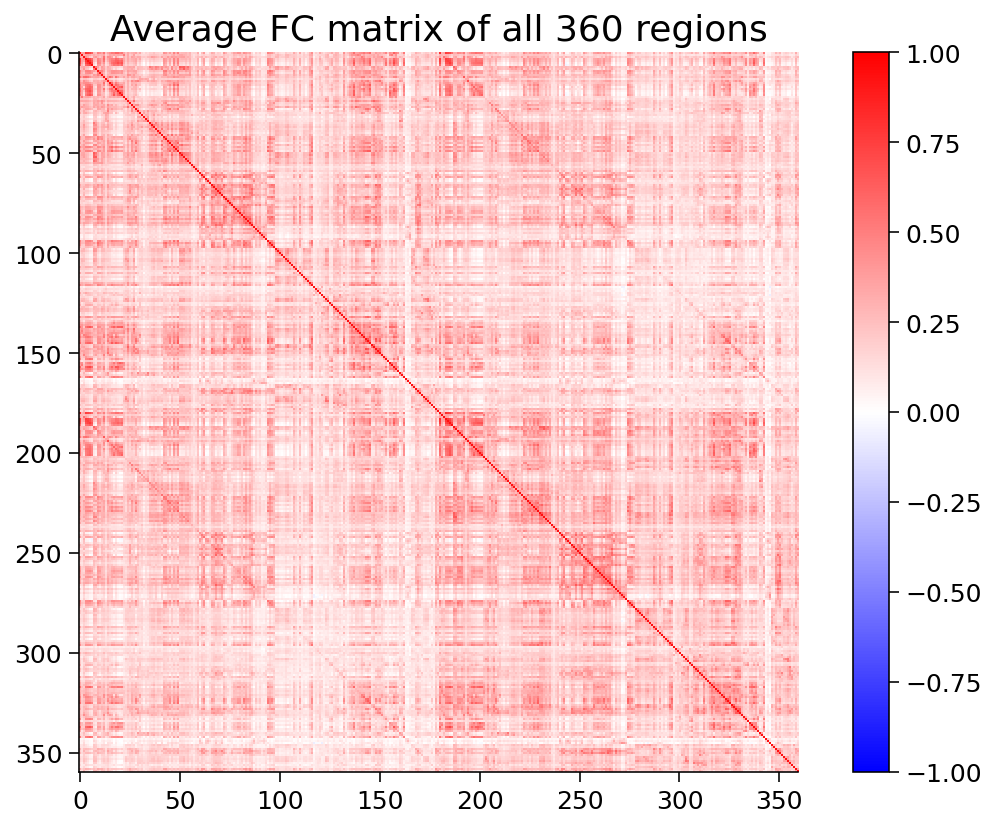

In [ ]:
fc = np.zeros((360, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_task_fc):
  if sub==81 or sub==143 or sub==329:
    continue
  fc[sub] = np.corrcoef(ts)
  #print(ts.shape)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Average FC matrix of all 360 regions")
plt.show()

In [ ]:
print(group_fc.shape)

(360, 360)


Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

In [ ]:
# Requires region names as a list which warrants a change in the "loading region information" section
# of the notebook to include .tolist()

seed_roi = "R_IP2"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

 Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

Calculate average FC values for all regions for individual subjects

In [ ]:
fc_roi_mean_all_360 = []

for subject in subjects:

  if subject==81 or subject==143 or subject==329:
    continue
  fc_360 = np.zeros([N_PARCELS, N_PARCELS])
  data_fc = load_timeseries(subject=subject, name='WM')

  #for ts in enumerate(data_fc):
  fc_360 = np.corrcoef(data_fc)

  fc_360_mean = np.mean(fc_360)
  fc_360_mean *= 360*360
  fc_360_mean -= 360
  fc_360_mean /= 129240
  
  fc_roi_mean_all_360.append(fc_360_mean)
#plt.imshow(fc_roi_triu, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
#plt.colorbar()
#plt.show()
print(len(fc_roi_mean_all_360))

336


## FC for 20 regions showing highest activity

Generate a correlation matrix (showing "functional connectivity") for each subject and top 20 regions and plot the group average

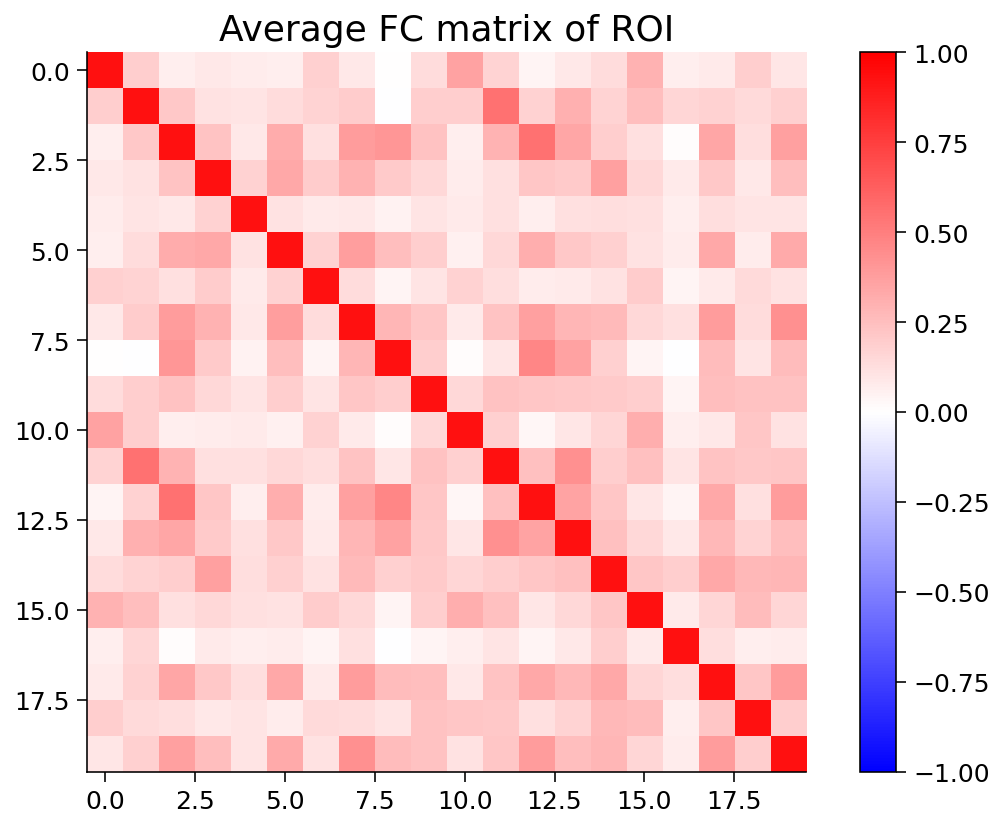

In [ ]:
group_fc_roi = np.zeros([20,20])
i=0
j=0

for roi in roi_wm:
  for roi2 in roi_wm:
    group_fc_roi[i][j] = group_fc[roi][roi2]
    j+=1
  j=0
  i+=1

plt.imshow(group_fc_roi, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.title("Average FC matrix of ROI")
plt.colorbar()
plt.show()

Threshold the correlation matrix to produce a connectome, and plot it:

In [ ]:
plotting.view_connectome(group_fc_roi, atlas["coords"], edge_threshold="95%")

Calculate average FC values for the top 20 regions for individual subjects and plot correlation matrix for any one subject

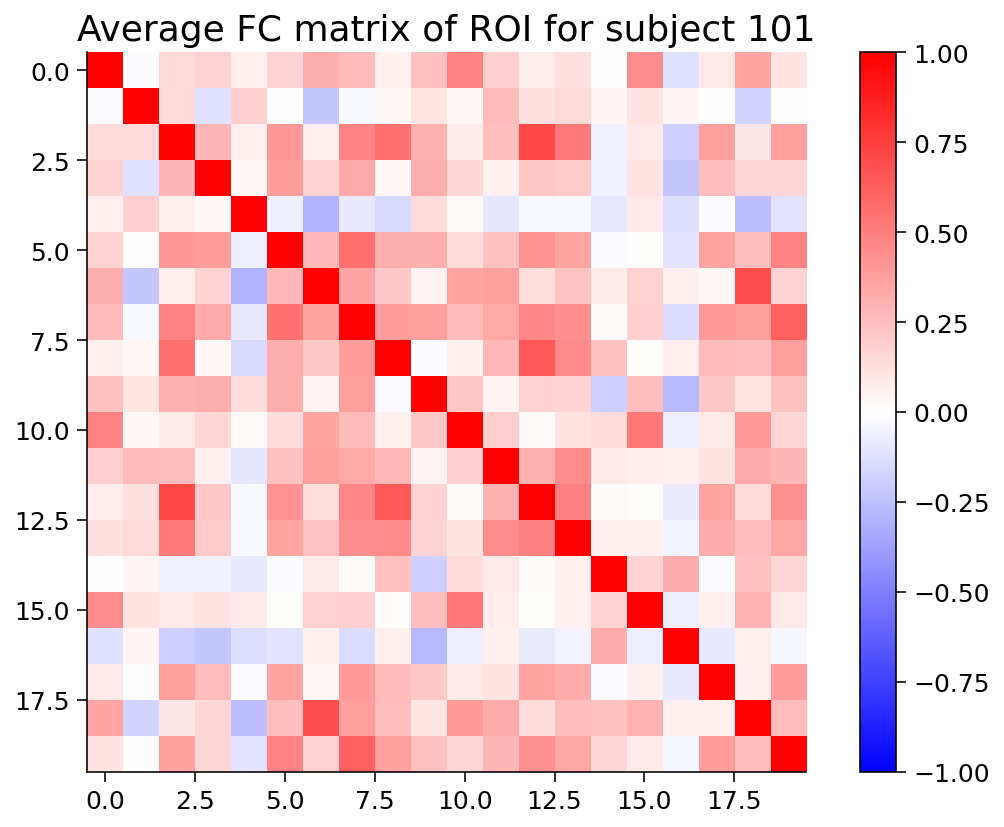

336


In [ ]:
fc_roi_mean_all = []

for subject in subjects:

  if subject==81 or subject==143 or subject==329:
    continue
  fc_roi = np.zeros([20,20])
  fc_360 = np.zeros([N_PARCELS, N_PARCELS])
  data_fc = load_timeseries(subject=subject, name='WM')

  #for ts in enumerate(data_fc):
  fc_360 = np.corrcoef(data_fc)

  l=0  
  k=0
  for roi in roi_wm:
    for roi2 in roi_wm:
      fc_roi[l][k] = fc_360[roi][roi2]
      k+=1
    k=0
    l+=1

  fc_roi_mean = np.mean(fc_roi)
  fc_roi_mean *= 400
  fc_roi_mean -= 20
  fc_roi_mean /= 380
  
  fc_roi_mean_all.append(fc_roi_mean)

  if subject==100:
    plt.imshow(fc_roi, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Average FC matrix of ROI for subject 101")
    plt.show()

#plt.show()
print(len(fc_roi_mean_all))

## Correlation Analysis of FC and average Median_RT

Correlation analysis of Functional Connectivity values across average median response times of 2 back condition of the Working Memory Task, across top 20 regions and all 360 regions

Though the results are not significant, a trend can be observed with FC values of top 20 regions giving a higher correlation with Median_RT with a lower p value

In [ ]:
corr_fc_rt = np.corrcoef(median_rt_avg, fc_roi_mean_all)
print(corr_fc_rt)

[[1.         0.07710173]
 [0.07710173 1.        ]]


In [ ]:
corr_fc_rt_scipy, p_value_fc_rt_scipy = scipy.stats.pearsonr(median_rt_avg, fc_roi_mean_all)
print(corr_fc_rt_scipy)
print(p_value_fc_rt_scipy)

# Returns a correlation value of 0.077
# Returns a p_value of 0.15

In [ ]:
corr_fc_rt_scipy, p_value_fc_rt_scipy = scipy.stats.pearsonr(median_rt_avg, fc_roi_mean_all_360)
print(corr_fc_rt_scipy)
print(p_value_fc_rt_scipy)

0.041735440282816956
0.4457589009722688


In [ ]:
plt.figure()
plt.title("Correlation=" + "{:.2f}".format(corr_fc_rt_scipy))
plt.scatter(median_rt_avg, fc_roi_mean_all_360, label = 'Median_RT_2bk v/s FC_ROI')
#plt.scatter(median_rt_avg, median_rt_avg*corr_fc_rt_scipy)
plt.plot(np.unique(median_rt_avg), np.poly1d(np.polyfit(median_rt_avg, fc_roi_mean_all, 1))(np.unique(median_rt_avg)), color='yellow', label = 'Best fit')
plt.xlabel("Median_RT_2bk")
plt.ylabel("FC_ROI")
plt.legend()
plt.show()

# Plot in presentation

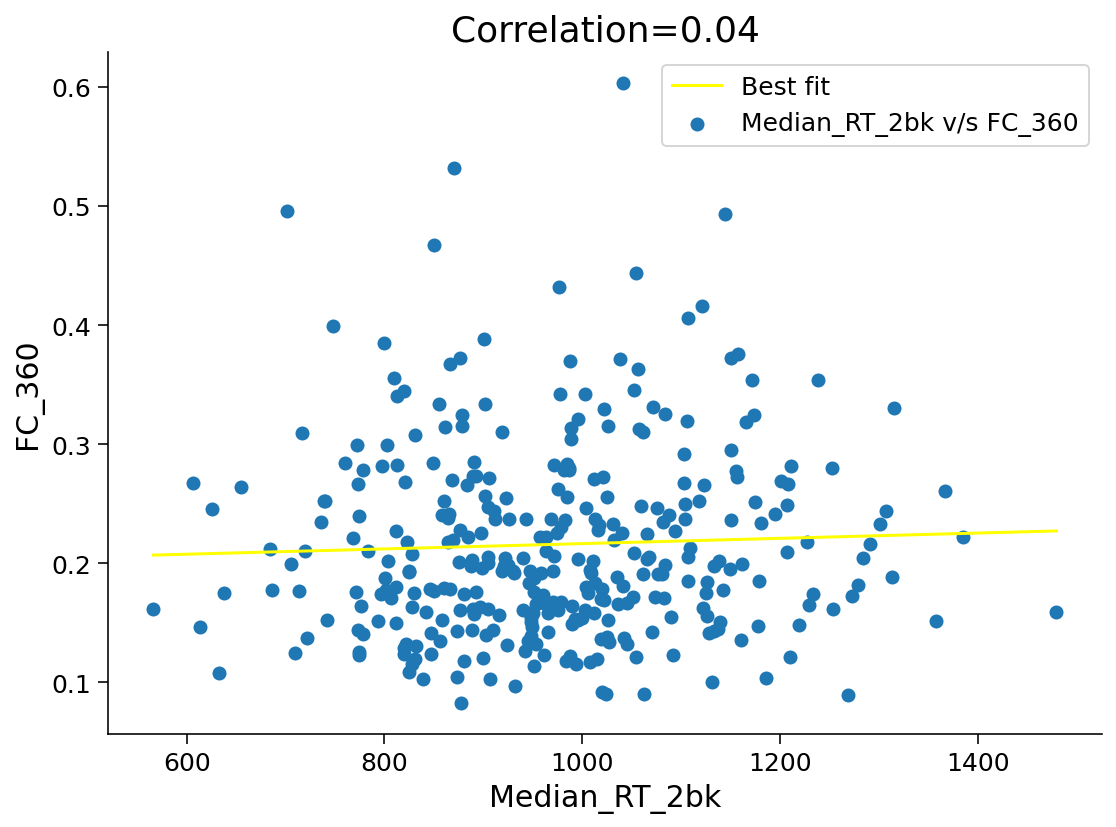

In [ ]:
plt.figure()
plt.title("Correlation=" + "{:.2f}".format(corr_fc_rt_scipy))
plt.scatter(median_rt_avg, fc_roi_mean_all_360, label = 'Median_RT_2bk v/s FC_360')
#plt.scatter(median_rt_avg, median_rt_avg*corr_fc_rt_scipy)
plt.plot(np.unique(median_rt_avg), np.poly1d(np.polyfit(median_rt_avg, fc_roi_mean_all_360, 1))(np.unique(median_rt_avg)), color='yellow', label = 'Best fit')
plt.xlabel("Median_RT_2bk")
plt.ylabel("FC_360")
plt.legend()
plt.show()

# Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

(339, 25)

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]
